In [57]:
%cd ../../..

/home/jupyter


In [115]:
from datasets_ import DatasetLoader

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample

import matplotlib.pyplot as plt
%matplotlib notebook

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AdamW

from tqdm import tqdm
import numpy as np
import pandas as pd

import sys

from nltk import WhitespaceTokenizer

from transformers import (
    pipeline,                       
    AutoModelForSequenceClassification,                       
    BertForSequenceClassification,                       
    AutoTokenizer,
    AdamW,
)

In [116]:
train, test = DatasetLoader.load_reviews_Review_Label_dataset(train_test_split=True,
                                                              classnames_to_int=True,
                                                              remove_neutral_class=True,
                                                              show_path=True,)
train.label[train['label'] == 2] = 1
test.label[test['label'] == 2] = 1

print(train.label.value_counts())
train = pd.concat([train, resample(train[train.label == 0], n_samples=41608, random_state=42)])
print(train.label.value_counts())

print(train.shape, test.shape)

/home/jupyter/work/resources/nlp-coursework/data/reviews_Review_Label/reviews_Review_Label.csv
1    48477
0     6869
Name: label, dtype: int64
1    48477
0    48477
Name: label, dtype: int64
(96954, 2) (23721, 2)


In [60]:
test

,review,label
25749,Большое количество фильмов советского кинемато...,1
44489,"Тяжело ответить на вопрос, что же такое Догвил...",1
53162,"В наше время такие героини, как скажем наприме...",0
25843,В 2001 году нам довелось познакомиться с новой...,1
44609,"«Это фильм?», «У них не хватило денег на декор...",1
...,...,...
14104,- Через столько лет?\r\n- Всегда\r\n\r\nБезусл...,1
22232,"После просмотра трейлера, я был под большим вп...",1
73314,"Многие не верят, но я легко подключаюсь к прои...",1
47848,"Как часто нам нужна поддержка? Да, пожалуй, оч...",1


In [73]:
# 

checkpoint = 'blanchefort/rubert-base-cased-sentiment-rusentiment'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/495 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/679M [00:00<?, ?B/s]

In [117]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_model_input_length=512):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_model_input_length = max_model_input_length
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        label = self.labels.iloc[idx]
        review_tokenized = self.tokenizer(
            review,
            add_special_tokens=True,
            max_length=self.max_model_input_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        input_ids = review_tokenized['input_ids'].flatten()
        attn_mask = review_tokenized['attention_mask'].flatten()
        
        return {
            'review': review,
            'input_ids': input_ids,
            'attention_mask': attn_mask,
            'label': label,
        }
        

In [44]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [120]:
class BertClassifier:
    def __init__(self, checkpoint, n_classes=2):
        
        self.model = BertForSequenceClassification.from_pretrained(checkpoint, local_files_only=False)
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.out_features = 768
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.5)
        
        self.all_losses = []
        self.epoch_losses = []
        self.epoch_acc = []       
        

    def fit(self):
        self.model.train()
        losses = []
        correct_predictions = 0
        
        t = tqdm(train_dataloader, file=sys.stdout, ncols=100)

        for data in t:
            input_ids = data['input_ids'].to(self.device)
            attention_mask = data['attention_mask'].to(self.device).to(float)
            labels = data['label'].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = outputs.logits.argmax(dim=1)
            
            loss = self.loss_fn(outputs.logits, labels)

            correct_predictions += torch.sum(preds == labels)

            losses.append(loss.item())

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            t.set_postfix(ordered_dict={'loss': loss.item()}, refresh=True)


        train_acc = correct_predictions.double() / len(train_dataset)
        train_loss = np.mean(losses)
        self.all_losses.extend(losses)
        self.epoch_losses.append(train_loss)
        self.epoch_acc.append(train_acc)
        return train_acc, train_loss
    
    
    def evaluate(self):
        self.model.eval()
        losses = []
        correct_predictions = 0
        
        all_preds = []
        
        t = tqdm(test_dataloader, file=sys.stdout, ncols=100)

        with torch.no_grad():
            for data in t:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                labels = data["label"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, labels)
                correct_predictions += torch.sum(preds == labels)
                
                all_preds.extend(preds.tolist())
                
                losses.append(loss.item())
                
                t.set_postfix(ordered_dict={'loss': loss.item()}, refresh=True)
                
        print('Classification report:')
        print(classification_report(test_dataset.labels, all_preds))

        val_acc = correct_predictions.double() / len(test_dataset)
        val_loss = np.mean(losses)
        return val_acc.item(), val_loss
    

    
    def train(self, n_epochs, pretrain_test=False):
        try:
            best_accuracy = 0

            if pretrain_test:
                print('Pre-training test:')
                val_acc, val_loss = self.evaluate()
                print(f'Test loss {val_loss} accuracy {val_acc}')
                print('-' * 10)

            for epoch in range(n_epochs):
                print(f'Epoch {epoch + 1}/{n_epochs}')
                train_acc, train_loss = self.fit()
                print(f'Train loss {train_loss} accuracy {train_acc}')

                val_acc, val_loss = self.evaluate()
                print(f'Test loss {val_loss} accuracy {val_acc}')
                print('-' * 10)
                
                # self.scheduler.step()
    
        except KeyboardInterrupt:
            print('Training was manually stopped. ')


In [121]:
#!g1.4

clf = BertClassifier('blanchefort/rubert-base-cased-sentiment-rusentiment')

train_dataset = ReviewDataset(train.review, train.label, clf.tokenizer)
test_dataset = ReviewDataset(test.review, test.label, clf.tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Downloading:   0%|          | 0.00/952 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/679M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [122]:
#!g1.4

for param in clf.model.bert.parameters():
    param.requires_grad = False
print('All parameters:', sum(p.numel() for p in clf.model.parameters()))
print('Trainable parameters:', sum(p.numel() for p in clf.model.parameters() if p.requires_grad))

All parameters: 177854978
Trainable parameters: 1538


#### batch_size=16, g1.1

In [94]:
#!g1.1

clf.model.device

device(type='cuda', index=0)

In [95]:
#!g1.1

# # batch_size = 16. First
clf.train(3, pretrain_test=True)

100%|███████████████████████████████████████████████| 6060/6060 [22:42<00:00,  4.45it/s, loss=0.249]
Train loss 0.3155554527957792 accuracy 0.8647709222930462
100%|███████████████████████████████████████████████| 1483/1483 [05:18<00:00,  4.66it/s, loss=0.331]
Classification report:
              precision    recall  f1-score   support

           0       0.59      0.82      0.68      2979
           1       0.97      0.92      0.94     20742

    accuracy                           0.91     23721
   macro avg       0.78      0.87      0.81     23721
weighted avg       0.92      0.91      0.91     23721

Test loss 0.22344129933490195 accuracy 0.9050630243244383
----------
Epoch 3/3
  9%|████▎                                           | 542/6060 [02:02<20:42,  4.44it/s, loss=0.528]
Training was manually stopped. 


In [103]:
#!g1.1

clf.optimizer.param_groups[0]['lr'] = 5e-5
clf.optimizer.param_groups[0]['lr']

5e-05

In [104]:
#!g1.1

for param in clf.model.bert.parameters():
    param.requires_grad = True
print('All parameters:', sum(p.numel() for p in clf.model.parameters()))
print('Trainable parameters:', sum(p.numel() for p in clf.model.parameters() if p.requires_grad))

All parameters: 177854978
Trainable parameters: 177854978


In [105]:
#!g1.1

clf.train(2, pretrain_test=True)

100%|███████████████████████████████████████████████| 6060/6060 [54:12<00:00,  1.86it/s, loss=0.672]
Train loss 0.30535650802991376 accuracy 0.8695566969903253
100%|███████████████████████████████████████████████| 1483/1483 [05:16<00:00,  4.68it/s, loss=0.337]
Classification report:
              precision    recall  f1-score   support

           0       0.60      0.83      0.70      2979
           1       0.97      0.92      0.95     20742

    accuracy                           0.91     23721
   macro avg       0.79      0.88      0.82     23721
weighted avg       0.93      0.91      0.92     23721

Test loss 0.2183518936394118 accuracy 0.9090257577673792
----------
Epoch 2/2
  5%|██▎                                             | 299/6060 [02:40<51:37,  1.86it/s, loss=0.279]
Training was manually stopped. 


---

#### batch_size=4, g1.4

In [123]:
#!g1.4

clf.train(3, pretrain_test=True)

100%|███████████████████████████████████████████████| 5931/5931 [05:03<00:00, 19.52it/s, loss=0.704]
Classification report:
              precision    recall  f1-score   support

           0       0.17      0.92      0.28      2979
           1       0.97      0.34      0.50     20742

    accuracy                           0.41     23721
   macro avg       0.57      0.63      0.39     23721
weighted avg       0.87      0.41      0.47     23721

Test loss 0.7023873747932712 accuracy 0.4114076135070191
----------
Epoch 1/3
  3%|█▌                                             | 786/24239 [00:44<22:12, 17.60it/s, loss=0.139]
Training was manually stopped. 


In [124]:
#!g1.1
clf.train(3, pretrain_test=False)

100%|███████████████████████████████████████████████| 5931/5931 [05:43<00:00, 17.25it/s, loss=0.106]
Classification report:
              precision    recall  f1-score   support

           0       0.54      0.86      0.67      2979
           1       0.98      0.90      0.93     20742

    accuracy                           0.89     23721
   macro avg       0.76      0.88      0.80     23721
weighted avg       0.92      0.89      0.90     23721

Test loss 0.2497088952682337 accuracy 0.8910248303191265
----------
Epoch 2/3
  6%|██▉                                           | 1559/24239 [01:35<23:15, 16.25it/s, loss=0.179]
Training was manually stopped. 


In [126]:
#!g1.1
clf.optimizer.param_groups[0]['lr'] = 2e-5

for param in clf.model.bert.parameters():
    param.requires_grad = True
print('All parameters:', sum(p.numel() for p in clf.model.parameters()))
print('Trainable parameters:', sum(p.numel() for p in clf.model.parameters() if p.requires_grad))

All parameters: 177854978
Trainable parameters: 177854978


In [127]:
#!g1.1
clf.train(1, pretrain_test=True)

100%|███████████████████████████████████████████████| 5931/5931 [05:43<00:00, 17.25it/s, loss=0.113]
Classification report:
              precision    recall  f1-score   support

           0       0.59      0.85      0.69      2979
           1       0.98      0.91      0.94     20742

    accuracy                           0.91     23721
   macro avg       0.78      0.88      0.82     23721
weighted avg       0.93      0.91      0.91     23721

Test loss 0.2258297441507776 accuracy 0.9058218456220227
----------


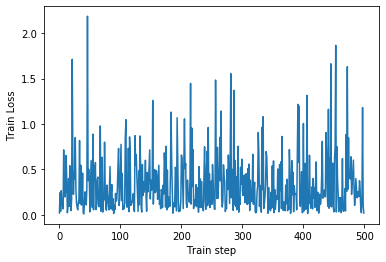

In [129]:
#!g1.1

plt.plot(clf.all_losses[-500:])
plt.xlabel('Train step')
plt.ylabel('Train Loss')

plt.show()

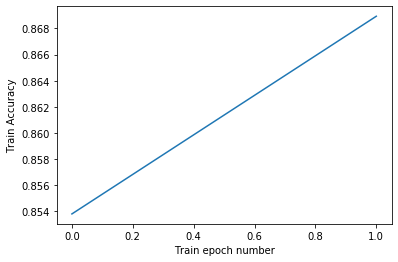

In [130]:
#!g1.1

clf.epoch_acc = list(map(lambda t: t.cpu(), clf.epoch_acc))

plt.plot(clf.epoch_acc)
plt.xlabel('Train epoch number')
plt.ylabel('Train Accuracy')

plt.show()

In [ ]:
plt.plot(clf.epoch_losses)
plt.xlabel('Train epoch number')
plt.ylabel('Train Loss')

plt.show()

In [ ]:
clf.model.save_pretrained('models/rubert_clf')
clf.tokenizer.save_pretrained('models/rubert_clf')